## Evaluating RAG and Agent Performance with RAGAS

### Overview

This demo walks through building a simple **Retrieval-Augmented Generation (RAG)** pipeline, converting it into a **LangGraph workflow with tool use**, and evaluating both using **RAGAS**, a framework for measuring the quality and correctness of RAG systems and agent responses.

In [1]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
from ragas import messages as ragas_messages
from ragas.integrations.langgraph import convert_to_ragas_messages
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import ToolCallAccuracy
from ragas.metrics import AgentGoalAccuracyWithReference

In [2]:
load_dotenv()

True

### **Building a Simple RAG Pipeline**

#### a. **Document Setup**

- A list of five documents is created, covering topics like Meta, Nvidia, Google, Intel, and Dell.
- Each `Document` object includes metadata such as `company` and `topic`.

In [3]:
documents = [
    Document(
        page_content="Meta drops multimodal Llama 3.2 — here's why it's such a big deal",
        metadata={"company":"Meta", "topic": "llama"}
    ),
    Document(
        page_content="Chip giant Nvidia acquires OctoAI, a Seattle startup that helps companies run AI models",
        metadata={"company":"Nvidia", "topic": "acquisition"}
    ),
    Document(
        page_content="Google is bringing Gemini to all older Pixel Buds",
        metadata={"company":"Google", "topic": "gemini"}
    ),
    Document(
        page_content="The first Intel Battlmage GPU benchmarks have leaked",
        metadata={"company":"Intel", "topic": "gpu"}
    ),
    Document(
        page_content="Dell partners with Nvidia to accelerate AI adoption in telecoms",
        metadata={"company":"Dell", "topic": "partnership"}
    ),
]

ids = ["id1", "id2", "id3", "id4", "id5"]

#### b. **Chroma Vector Store**

- A Chroma vector store is created using OpenAI embeddings and documents are added to it.

In [4]:
vector_store = Chroma(
    collection_name="demo",
    embedding_function=OpenAIEmbeddings(),
)

vector_store.add_documents(documents=documents, ids=ids)
retriever = vector_store.as_retriever(search_kwargs={"k": 1})

#### c. **RAG Chain**

- A simple prompt-based chain is constructed:
    - Prompt: "Answer the question based only on the following context: {context}"
    - Chain: Prompt → LLM → Output parser

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [6]:
prompt = ChatPromptTemplate.from_template(
    """Answer the question based only on the following context:
    {context}

    Question: {query}
    """
)

chain = prompt | llm | StrOutputParser()

In [7]:
def format_docs(relevant_docs):
    return "\n".join(doc.page_content for doc in relevant_docs)

#### d. **Invocation Example**

- Query: *"Who is partnering with Nvidia?"*
- Answer returned: *"Dell"* — correctly retrieved from the document set.

In [8]:
query = "Who is partnering with Nvidia?"
relevant_docs = retriever.invoke(query)
chain.invoke({"context": format_docs(relevant_docs), "query": query})

'Dell is partnering with Nvidia.'

### **Evaluating the RAG Pipeline with RAGAS**

#### a. **Evaluation Dataset Creation**

- Five example queries and expected responses are prepared.
- For each, relevant documents are retrieved and responses generated.
- A `EvaluationDataset` is created using these entries.

In [9]:
sample_queries = [
    "What is Meta's latest development in AI?",
    "Which company did Nvidia acquire?",
    "What AI feature is Google adding to older Pixel Buds?",
    "What recent information has leaked about Intel GPUs?",
    "Which company did Dell partner with to accelerate AI adoption?"
]

In [10]:
expected_responses = [
    "Meta drops multimodal Llama 3.2 — here's why it's such a big deal",
    "Chip giant Nvidia acquires OctoAI, a Seattle startup that helps companies run AI models",
    "Google is bringing Gemini to all older Pixel Buds",
    "The first Intel Battlemage GPU benchmarks have leaked",
    "Dell partners with Nvidia to accelerate AI adoption in telecoms"
]

In [11]:
dataset = []

for query, reference in zip(sample_queries, expected_responses):
    relevant_docs = retriever.invoke(query)
    response = chain.invoke(
        {
            "context": format_docs(relevant_docs), 
            "query": query
        }
    )
    dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [doc.page_content for doc in relevant_docs],
            "response": response,
            "reference": reference,
        }
    )

evaluation_dataset = EvaluationDataset.from_list(dataset)

#### b. **Metrics Used**

- RAGAS metrics include:
    - `LLMContextRecall`
    - `Faithfulness`
    - `FactualCorrectness`

In [ ]:
metrics = [LLMContextRecall(), Faithfulness(), FactualCorrectness()]

#### c. **Execution**

- `evaluate()` is called with the evaluation dataset and the wrapped LLM.

In [ ]:
evaluator_llm = LangchainLLMWrapper(llm)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=metrics,
    llm=evaluator_llm,
)

result

{'context_recall': 1.0000, 'faithfulness': 1.0000, 'factual_correctness(mode=f1)': 0.5400}

### **Creating an Agent Workflow in LangGraph**

#### a. **Tool Definition**

- A custom `get_pokemon_type` tool is defined to return Pokémon types by name.

In [14]:
pokemon_types_map = {
    "pikachu": "electric",
    "eevee": "normal",
    "bulbasaur": "grass/poison",
    "squirtle": "water",
    "charizard": "fire/flying",
    "jigglypuff": "normal/fairy",
    "meowth": "normal",
    "psyduck": "water",
    "machamp": "fighting",
    "gengar": "ghost/poison",
    "alakazam": "psychic",
    "snorlax": "normal",
    "dragonite": "dragon/flying",
}

In [15]:
@tool
def get_pokemon_type(pokemon_name: str) -> str:
    """Fetches the type of the specified Pokémon.

    Args:
        pokemon_name : The name of the Pokémon (e.g., 'pikachu', 'charizard', 'eevee').

    Returns:
        str: The type(s) of the Pokémon.

    Raises:
        KeyError: If the specified Pokémon is not found in the data source.
    """
    try:
        pokemon_name = pokemon_name.lower().strip()
        if pokemon_name not in pokemon_types_map:
            raise KeyError(
                f"Pokémon '{pokemon_name}' not found. Available Pokémon: {', '.join(pokemon_types.keys())}"
            )
        return pokemon_types_map[pokemon_name]
    except Exception as e:
        raise Exception(f"Error fetching Pokémon type: {str(e)}")

In [16]:
tools = [get_pokemon_type]

In [17]:
llm_with_tools = llm.bind_tools(tools)

#### b. **LangGraph Construction**

- A simple agent workflow is created:
    - Agent node → Conditional tool call → Tool node → Back to agent or end
- Standard ReAct-style flow.

In [18]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [19]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [20]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


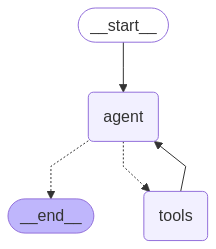

In [21]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

#### c. **Invocation Example**

- Input: *"What is the Gengar's type?"*
- The agent correctly calls the tool and responds: *"ghost/poison"*

In [22]:
result = graph.invoke(
    {"messages": [HumanMessage(content="What is the Gengar's type?")]}
)

In [23]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the Gengar's type?
================================== Ai Message ==================================
Tool Calls:
  get_pokemon_type (call_r1L0ol6e2yOtyFXkC1U2DSgy)
 Call ID: call_r1L0ol6e2yOtyFXkC1U2DSgy
  Args:
    pokemon_name: gengar
================================= Tool Message =================================
Name: get_pokemon_type

ghost/poison
================================== Ai Message ==================================

Gengar is a Ghost/Poison type Pokémon.


### **Evaluating the Agent with RAGAS**

#### a. **Conversion to RAGAS Format**

- LangGraph message trace is converted to RAGAS-compatible format using `convert_to_ragas_messages()`.

In [24]:
ragas_trace = convert_to_ragas_messages(result["messages"])

In [25]:
ragas_trace

[HumanMessage(content="What is the Gengar's type?", metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_pokemon_type', args={'pokemon_name': 'gengar'})]),
 ToolMessage(content='ghost/poison', metadata=None, type='tool'),
 AIMessage(content='Gengar is a Ghost/Poison type Pokémon.', metadata=None, type='ai', tool_calls=[])]

#### b. **Tool Call Accuracy**

- Measured using `ToolCallAccuracy` metric.
- Reference includes expected tool call and arguments.

In [26]:
sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        ragas_messages.ToolCall(
            name="get_pokemon_type", 
            args={"pokemon_name": "gengar"}
        )
    ],
)

In [27]:
scorer = ToolCallAccuracy()
scorer.llm = llm

In [28]:
await scorer.multi_turn_ascore(sample)

1.0

#### c. **Agent Goal Accuracy**

- Measures whether the agent achieved the intended result.
- Uses `AgentGoalAccuracyWithReference`.

In [29]:
sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="What is the Gengar's type?",
)

In [30]:
scorer = AgentGoalAccuracyWithReference()
scorer.llm = LangchainLLMWrapper(llm)

In [31]:
await scorer.multi_turn_ascore(sample)

1.0

### **Key Concepts Highlighted**

- RAG pipelines can be **evaluated objectively** for performance and correctness using RAGAS.
- LangGraph workflows with **tool calls** can be tested just like standard RAG flows.
- Metrics such as **faithfulness**, **factual correctness**, and **tool call accuracy** enable deep insights into agent behavior.
- Agent performance can be reliably benchmarked and improved iteratively.

### **Conclusion**

- RAGAS is a powerful toolkit for evaluating the effectiveness of both retrieval-based systems and agent workflows.
- This demo shows how to apply evaluation metrics in both traditional and tool-augmented pipelines to ensure system quality and correctness.